In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
%matplotlib inline

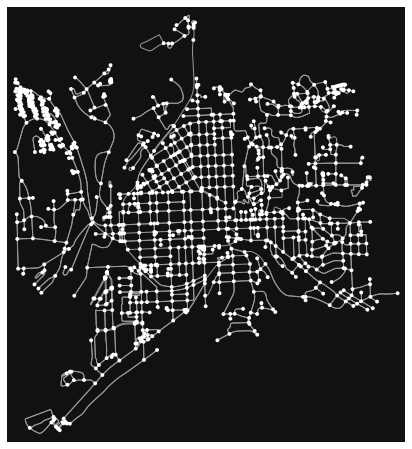

In [69]:
place = 'Ithaca, New York, USA'
gdf = ox.geocode_to_gdf(place)
area = ox.project_gdf(gdf).unary_union.area

G = ox.graph_from_place(place, network_type='drive_service')
fig, ax = ox.plot_graph(G)

In [7]:
#calculate basic and extended network stats, merge them together, and display

stats = ox.basic_stats(G, area=area)
extended_stats = ox.extended_stats(G, ecc=True,     #eccentricity
                                  bc=True,          #between centrality
                                   cc=True          #closeness centrality
                                  )
for key, value in extended_stats.items():
    stats[key] = value
    
pd.Series(stats)

n                                                                                   1177
m                                                                                   2982
k_avg                                                                            5.06712
intersection_count                                                                   916
streets_per_node_avg                                                             2.73407
streets_per_node_counts                 {0: 0, 1: 261, 2: 9, 3: 696, 4: 206, 5: 3, 6: 2}
streets_per_node_proportion            {0: 0.0, 1: 0.221750212404418, 2: 0.0076465590...
edge_length_total                                                                 294405
edge_length_avg                                                                  98.7273
street_length_total                                                               158632
street_length_avg                                                                99.3311
street_segments_count

### Check streets & interection counts/ proportion

In [8]:
# unpack nested dicts in basic stats into individual keys:values

for k, count in stats['streets_per_node_counts'].items():
    stats['streets_bynode_count_{}'.format(k)] = count
    
for k, proportion in stats['streets_per_node_proportion'].items():
    stats['streets_bynode_proportion_{}'.format(k)] = proportion
    
del stats['streets_per_node_counts']
del stats['streets_per_node_proportion']

pd.DataFrame(pd.Series(stats, name = 'value'))


,value
n,1177
m,2982
k_avg,5.06712
intersection_count,916
streets_per_node_avg,2.73407
edge_length_total,294405
edge_length_avg,98.7273
street_length_total,158632
street_length_avg,99.3311
street_segments_count,1597


### Investigate Betweeness Centrality

In [13]:
# project graph to the UTM CRS for the UTM zone in which the graph's centroid lies (by default)

G_projected = ox.project_graph(G)

In [25]:
max_node, max_bc = max(extended_stats['betweenness_centrality'].items(), key=lambda x:x[1])    #items() lists both keys, values 
max_node, max_bc

(213437717, 0.26091909104067157)

In [20]:
max_node, max_bc = max(extended_stats['betweenness_centrality'].items())    # Doing this only returns highest key (incorrect)
max_node, max_bc

(7683965528, 0.0)

In [26]:
max(extended_stats['betweenness_centrality'], key= extended_stats['betweenness_centrality'].get)    # doing this gives the key of highest value

213437717

In [27]:
max(extended_stats['betweenness_centrality'].values())    # confirm this is the highest value in the dict

0.26091909104067157

### Plot node with highest betweeness centrality in Ithaca
It has ~26% of the shortest paths running through it 

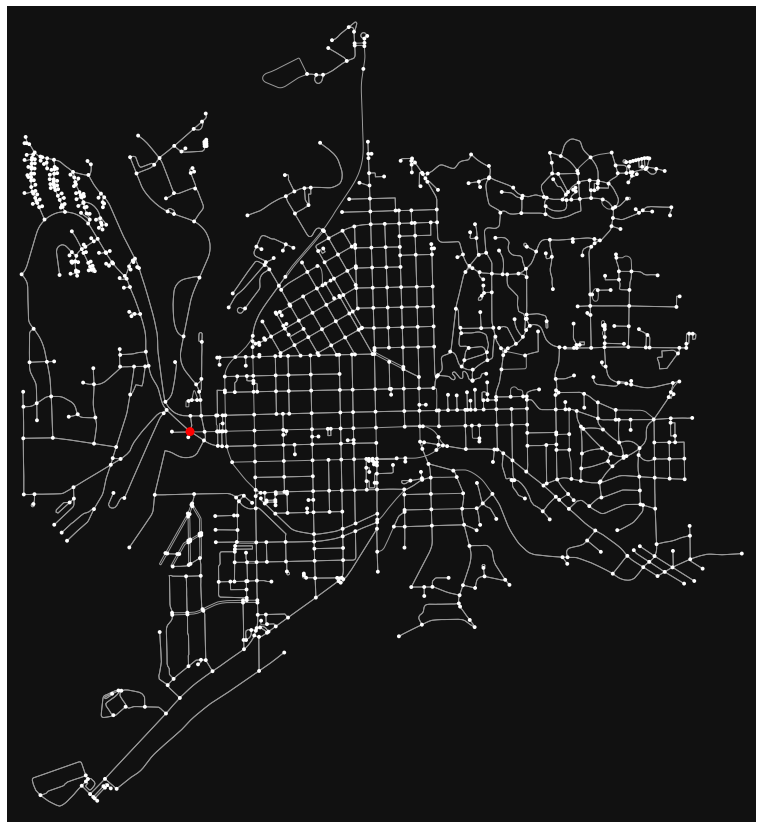

In [54]:
nc = ['r' if node==max_node else 'w' for node in G_projected.nodes()]
ns = [80 if node==max_node else 15 for node in G_projected.nodes()]


fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, figsize=(20,15))

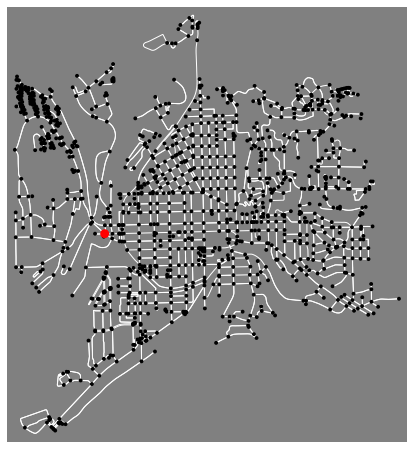

In [44]:
#Customisable colour palette

fig, ax = ox.plot_graph(G_projected, node_size=ns, node_color=nc, 
                        node_zorder=2,    # use =0 to plot nodes below edges, default=1  
                        bgcolor='grey',   # background colour of plot 
                        edge_color='w')

### Compare Relative betweeness centrality
Nodes in Ithaca with relatively high betweeness centrality (more prone to failure/ inefficiency)

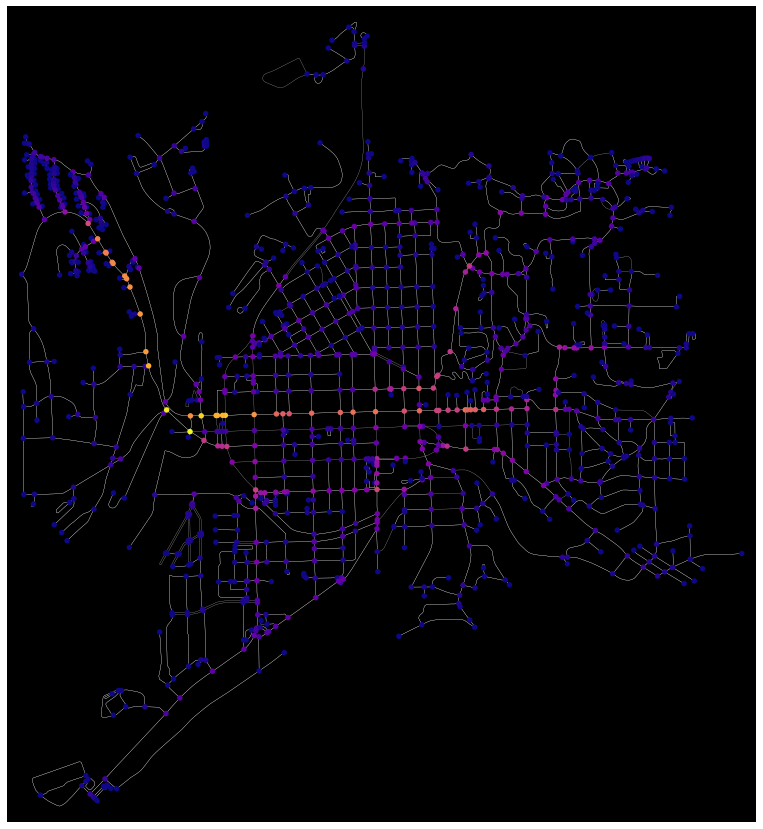

In [68]:
nx.set_node_attributes(G_projected, extended_stats['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G_projected, 'bc', cmap='plasma')

fig, ax = ox.plot_graph(G_projected, node_color=nc, node_size=30, 
                        edge_linewidth=0.2, edge_color='w', bgcolor='k', 
                       figsize=(20,15))

In [70]:
# Do one for biking instead of driving

G = ox.graph_from_place(place, network_type='bike')

In [71]:
stats_bike = ox.basic_stats(G, area=area)
extended_stats_bike = ox.extended_stats(G, ecc=True,     #eccentricity
                                  bc=True,          #between centrality
                                   cc=True          #closeness centrality
                                  )
for key, value in extended_stats.items():
    stats_bike[key] = value

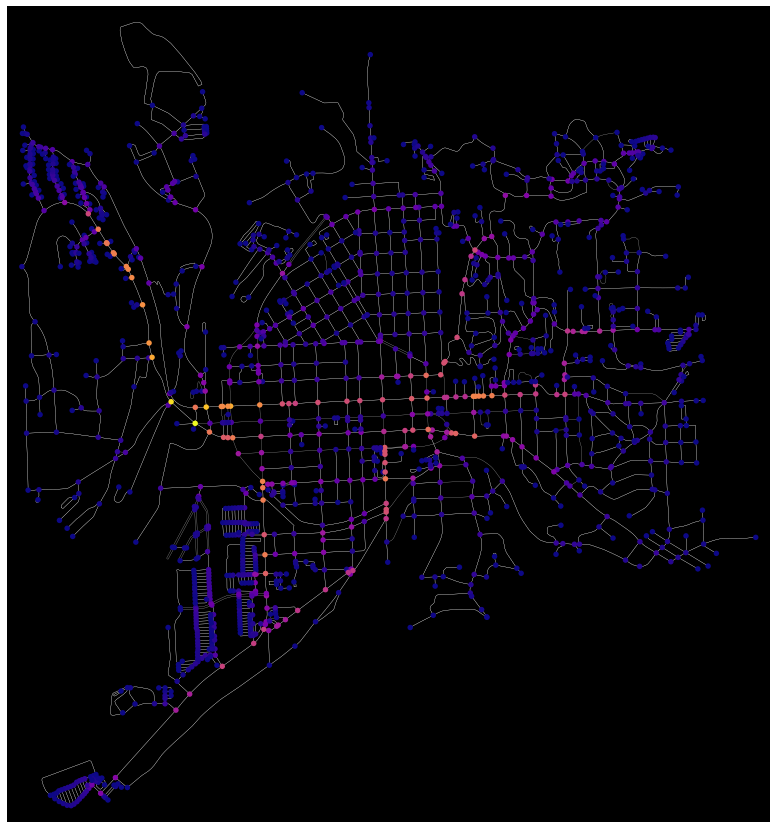

In [72]:
nx.set_node_attributes(G, extended_stats_bike['betweenness_centrality'], 'bc')
nc = ox.plot.get_node_colors_by_attr(G, 'bc', cmap='plasma')

fig, ax = ox.plot_graph(G, node_color=nc, node_size=30, 
                        edge_linewidth=0.2, edge_color='w', bgcolor='k', 
                       figsize=(20,15))

### Plot street network over shape

In [61]:
from descartes import PolygonPatch
from shapely.geometry import Polygon, MultiPolygon

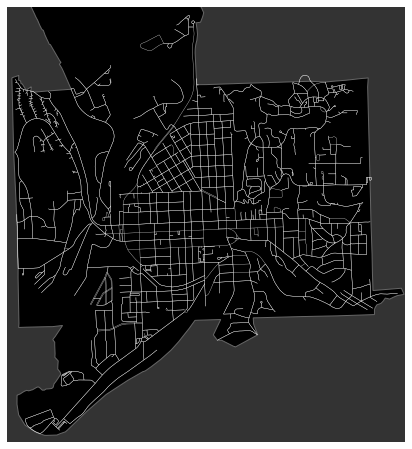

In [64]:
gdf = ox.geocode_to_gdf('Ithaca, NY')

fig, ax = ox.plot_graph(G, show=False, close=False, bgcolor='#333333',         # doesn't work with G_projected
                        edge_color='w', edge_linewidth=0.3, node_size=0)

# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in gdf['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='k', ec='#666666', lw=1, alpha=1, zorder=-1)
            ax.add_patch(patch)

### Highlight One-way streets

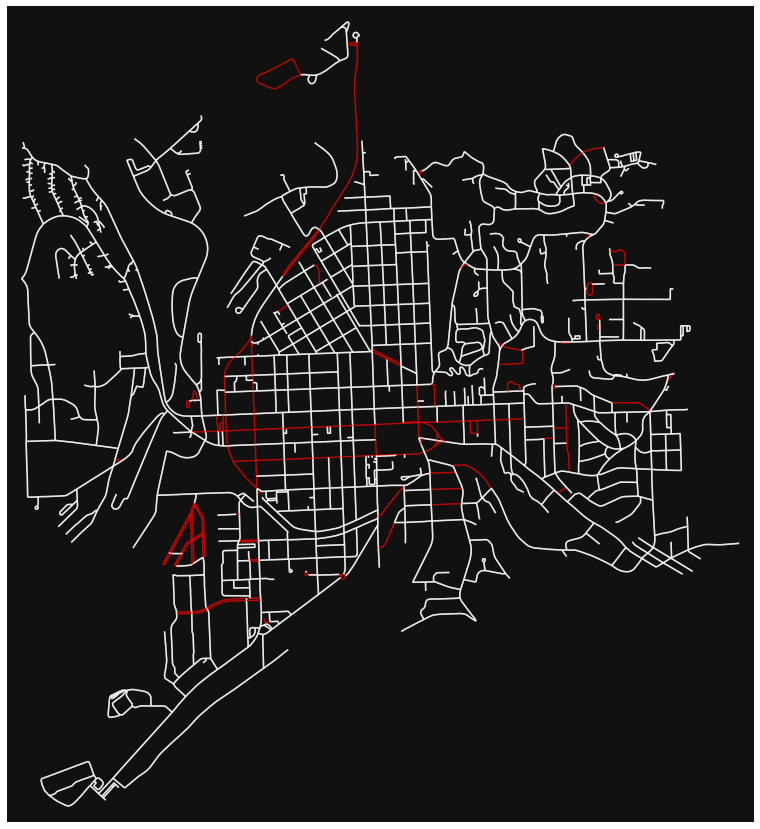

In [47]:
ec = ['r' if data['oneway'] else 'w' for u,v,keys,data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7, figsize=(20,15))

### Calculate centrality

In [4]:
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, 'edge centrality')

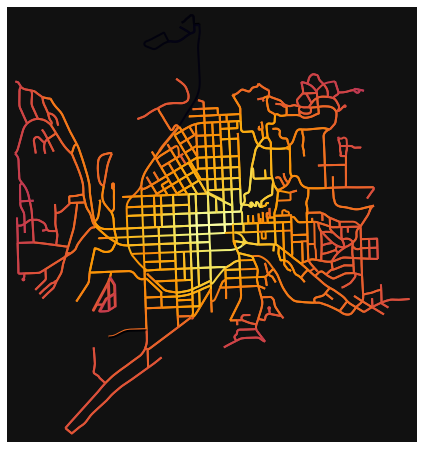

In [5]:
ec = ox.plot.get_edge_colors_by_attr(G, 'edge centrality', cmap='inferno')
fig,ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=2, node_size=0)

### Test an address

In [6]:
G = ox.graph_from_address(address= '911 East Shore Drive, Ithaca, NY', dist=100,
                         dist_type='network', network_type='walk')

In [7]:
G_proj = ox.project_graph(G)

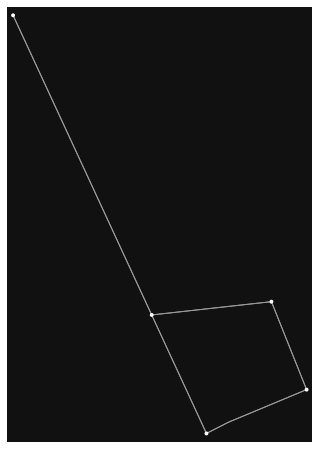

In [8]:
fig, ax = ox.plot_graph(G)